In [31]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *
from models.DeepModels import *
from models.DeepUtils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant
from torch.utils.data import DataLoader

random.seed(RANDOM_STATE)

# Action recognition

In [32]:
part_name = 's6'
use_saved = True

In [33]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [34]:
test_size = 0.3
pca_expl_var = 0.95

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [35]:
if use_saved and os.path.exists(f'saved/features_{part_name}_ExObs.h5'):
    features = pd.read_hdf(f'saved/features_{part_name}_ExObs.h5', 'df')
else:
    features = participant.get_features_all_sessions_ExObs()
    features.to_hdf(f'saved/features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)

In [36]:
print(f'The dataset contains {features.shape[0]} samples and {features.shape[1]} features.')
print(f'The {len(participant.relevant_channels_ex)} relevant channels are located in the following locations:')
regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_ex]]
channels_per_regions = {}
for region in set(regions):
    channels_per_regions[region] = regions.count(region)
print(channels_per_regions)

The dataset contains 256 samples and 2881 features.
The 68 relevant channels are located in the following locations:
{'postcentral': 16, 'superiorfrontal': 5, 'WM_insula': 1, 'insula': 3, 'WM_precentral': 6, 'WM_paracentral': 1, 'precentral': 26, 'paracentral': 3, 'supramarginal': 3, 'caudalmiddlefrontal': 4}


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [37]:
use_saved = False

In [38]:
if use_saved and os.path.exists(f'saved/baseline_features_{part_name}_ExObs.h5'):
    baseline_features = pd.read_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df')
else:
    baseline_features = participant.get_features_all_sessions_unresponsive(len(participant.relevant_channels_both), movtype=None)
    baseline_features.to_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)

100%|██████████| 256/256 [06:39<00:00,  1.56s/it]
C:\Users\sarah\AppData\Local\Temp\ipykernel_23264\1010671631.py:5: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  baseline_features.to_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)


In [39]:
print(f'The baseline dataset contains {baseline_features.shape[0]} samples and {baseline_features.shape[1]} features.')

The baseline dataset contains 256 samples and 2737 features.


In [40]:
accuracies = {}
accuracies_baseline = {}

### Train a model on the baseline features (Logistic Regression)

In [41]:
X = baseline_features.drop('label', axis=1)
y = baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['Logistic Regression'] = accuracy

Accuracy: 0.68


#### With PCA

In [42]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['Logistic Regression PCA'] = accuracy

Accuracy: 0.61


### Train a model (SVM)

In [43]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['SVM'] = accuracy

Accuracy: 0.65


#### With PCA

In [44]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['SVM PCA'] = accuracy

Accuracy: 0.66


### Train a model (Random Forest)

In [ ]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['Random Forest'] = accuracy

Accuracy: 0.65


### Train a model (Multi-Layer Perceptron)

In [46]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(X_train.shape[1], 2, layers=(16, 16))
trainset = DfDataset(X_train, y_train)
valset = DfDataset(X_val, y_val)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=4)

trainer = Trainer(mlp, 0.1, 20, 4, save_path='saved/mlp.pth', device=device)
trainer.train(train_loader, val_loader)

Epoch 1/20 - Training: 100%|██████████| 45/45 [00:02<00:00, 15.16it/s]


Epoch: 1 	Training Loss: 2.388744 	Training Acc: 0.502793


Epoch 1/20 - Validation: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Epoch: 1 	Validation Loss: 0.692354 	Validation Acc: 0.526316
Validation loss decreased (inf --> 0.692354). Saving model ...


Epoch 2/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 14.73it/s]


Epoch: 2 	Training Loss: 0.818460 	Training Acc: 0.474860


Epoch 2/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch: 2 	Validation Loss: 0.714362 	Validation Acc: 0.473684


Epoch 3/20 - Training: 100%|██████████| 45/45 [00:02<00:00, 15.35it/s]


Epoch: 3 	Training Loss: 0.711774 	Training Acc: 0.513966


Epoch 3/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch: 3 	Validation Loss: 0.691893 	Validation Acc: 0.526316
Validation loss decreased (0.692354 --> 0.691893). Saving model ...


Epoch 4/20 - Training: 100%|██████████| 45/45 [00:02<00:00, 15.18it/s]


Epoch: 4 	Training Loss: 0.695915 	Training Acc: 0.508380


Epoch 4/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch: 4 	Validation Loss: 0.699072 	Validation Acc: 0.473684


Epoch 5/20 - Training: 100%|██████████| 45/45 [00:02<00:00, 15.17it/s]


Epoch: 5 	Training Loss: 0.703421 	Training Acc: 0.469274


Epoch 5/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch: 5 	Validation Loss: 0.692035 	Validation Acc: 0.526316


Epoch 6/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 13.24it/s]


Epoch: 6 	Training Loss: 0.702701 	Training Acc: 0.497207


Epoch 6/20 - Validation: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch: 6 	Validation Loss: 0.715752 	Validation Acc: 0.473684


Epoch 7/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 14.68it/s]


Epoch: 7 	Training Loss: 0.707875 	Training Acc: 0.474860


Epoch 7/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch: 7 	Validation Loss: 0.701528 	Validation Acc: 0.473684


Epoch 8/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 13.30it/s]


Epoch: 8 	Training Loss: 0.715274 	Training Acc: 0.458101


Epoch 8/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch: 8 	Validation Loss: 0.696397 	Validation Acc: 0.526316


Epoch 9/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 13.74it/s]


Epoch: 9 	Training Loss: 0.707561 	Training Acc: 0.474860


Epoch 9/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch: 9 	Validation Loss: 0.703593 	Validation Acc: 0.473684


Epoch 10/20 - Training: 100%|██████████| 45/45 [00:02<00:00, 15.15it/s]


Epoch: 10 	Training Loss: 0.707336 	Training Acc: 0.508380


Epoch 10/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch: 10 	Validation Loss: 0.730657 	Validation Acc: 0.473684


Epoch 11/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 14.23it/s]


Epoch: 11 	Training Loss: 0.732426 	Training Acc: 0.452514


Epoch 11/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Epoch: 11 	Validation Loss: 0.697249 	Validation Acc: 0.473684


Epoch 12/20 - Training: 100%|██████████| 45/45 [00:02<00:00, 15.12it/s]


Epoch: 12 	Training Loss: 0.703576 	Training Acc: 0.530726


Epoch 12/20 - Validation: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Epoch: 12 	Validation Loss: 0.701509 	Validation Acc: 0.473684


Epoch 13/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 13.11it/s]


Epoch: 13 	Training Loss: 0.705315 	Training Acc: 0.497207


Epoch 13/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch: 13 	Validation Loss: 0.700189 	Validation Acc: 0.473684


Epoch 14/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 14.18it/s]


Epoch: 14 	Training Loss: 0.711210 	Training Acc: 0.452514


Epoch 14/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch: 14 	Validation Loss: 0.704701 	Validation Acc: 0.473684


Epoch 15/20 - Training: 100%|██████████| 45/45 [00:02<00:00, 15.43it/s]


Epoch: 15 	Training Loss: 0.703174 	Training Acc: 0.513966


Epoch 15/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch: 15 	Validation Loss: 0.691770 	Validation Acc: 0.526316
Validation loss decreased (0.691893 --> 0.691770). Saving model ...


Epoch 16/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 13.81it/s]


Epoch: 16 	Training Loss: 0.702747 	Training Acc: 0.446927


Epoch 16/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 16 	Validation Loss: 0.691765 	Validation Acc: 0.526316
Validation loss decreased (0.691770 --> 0.691765). Saving model ...


Epoch 17/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 14.29it/s]


Epoch: 17 	Training Loss: 0.701546 	Training Acc: 0.502793


Epoch 17/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 17 	Validation Loss: 0.701857 	Validation Acc: 0.526316


Epoch 18/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 13.99it/s]


Epoch: 18 	Training Loss: 0.707042 	Training Acc: 0.469274


Epoch 18/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch: 18 	Validation Loss: 0.699909 	Validation Acc: 0.526316


Epoch 19/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 11.77it/s]


Epoch: 19 	Training Loss: 0.711012 	Training Acc: 0.391061


Epoch 19/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Epoch: 19 	Validation Loss: 0.691811 	Validation Acc: 0.526316


Epoch 20/20 - Training: 100%|██████████| 45/45 [00:03<00:00, 14.86it/s]


Epoch: 20 	Training Loss: 0.697450 	Training Acc: 0.508380


Epoch 20/20 - Validation: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

Epoch: 20 	Validation Loss: 0.696716 	Validation Acc: 0.473684


In [48]:
testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = trainer.model(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_baseline['MLP'] = acc

Accuracy: 0.49


## Let's now do the analysis for the responsive channels

In [49]:
X = features.drop('label', axis=1)
y = features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [50]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['Logistic Regression'] = accuracy

Accuracy: 0.99


#### With PCA

In [51]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['Logistic Regression PCA'] = accuracy

Accuracy: 1.00


### Train a model (SVM)

In [52]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['SVM'] = accuracy

Accuracy: 0.99


#### With PCA

In [53]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['SVM PCA'] = accuracy

Accuracy: 0.99


### Train a model (Random Forest)

In [ ]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['Random Forest'] = accuracy

Accuracy: 1.00


### Train a model (Multi-Layer Perceptron)

In [55]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(X_train.shape[1], 2, layers=(16, 16))
trainset = DfDataset(X_train, y_train)
valset = DfDataset(X_val, y_val)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
val_loader = DataLoader(valset, batch_size=4, shuffle=False)

trainer = Trainer(mlp, 0.1, 10, 1e-3, save_path='saved/mlp.pth', device=device)
trainer.train(train_loader, val_loader)

Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 392.68it/s]


Epoch: 1 	Training Loss: 9.096034 	Training Acc: 0.804469


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<?, ?it/s]


Epoch: 1 	Validation Loss: 0.664366 	Validation Acc: 0.921053
Validation loss decreased (inf --> 0.664366). Saving model ...


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 541.90it/s]


Epoch: 2 	Training Loss: 1.877060 	Training Acc: 0.636872


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 613.51it/s]


Epoch: 2 	Validation Loss: 0.552368 	Validation Acc: 0.763158
Validation loss decreased (0.664366 --> 0.552368). Saving model ...


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 543.79it/s]


Epoch: 3 	Training Loss: 0.595654 	Training Acc: 0.648045


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1377.39it/s]


Epoch: 3 	Validation Loss: 0.602970 	Validation Acc: 0.394737


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 559.86it/s]


Epoch: 4 	Training Loss: 0.586446 	Training Acc: 0.614525


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2834.76it/s]


Epoch: 4 	Validation Loss: 0.589734 	Validation Acc: 0.394737


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 542.02it/s]


Epoch: 5 	Training Loss: 0.566618 	Training Acc: 0.614525


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1814.77it/s]


Epoch: 5 	Validation Loss: 0.436278 	Validation Acc: 0.815789
Validation loss decreased (0.552368 --> 0.436278). Saving model ...


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 579.46it/s]


Epoch: 6 	Training Loss: 0.562142 	Training Acc: 0.681564


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 769.16it/s]


Epoch: 6 	Validation Loss: 0.438960 	Validation Acc: 0.815789


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 515.62it/s]


Epoch: 7 	Training Loss: 0.573241 	Training Acc: 0.625698


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<?, ?it/s]


Epoch: 7 	Validation Loss: 0.540970 	Validation Acc: 0.815789


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 542.70it/s]


Epoch: 8 	Training Loss: 0.555651 	Training Acc: 0.681564


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<?, ?it/s]


Epoch: 8 	Validation Loss: 0.482751 	Validation Acc: 0.815789


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 563.47it/s]


Epoch: 9 	Training Loss: 0.577881 	Training Acc: 0.631285


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<?, ?it/s]


Epoch: 9 	Validation Loss: 0.499698 	Validation Acc: 0.815789


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 565.06it/s]


Epoch: 10 	Training Loss: 0.559794 	Training Acc: 0.681564


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2681.78it/s]

Epoch: 10 	Validation Loss: 0.482487 	Validation Acc: 0.815789


In [57]:
testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = trainer.model(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies['MLP'] = acc

Accuracy: 0.62


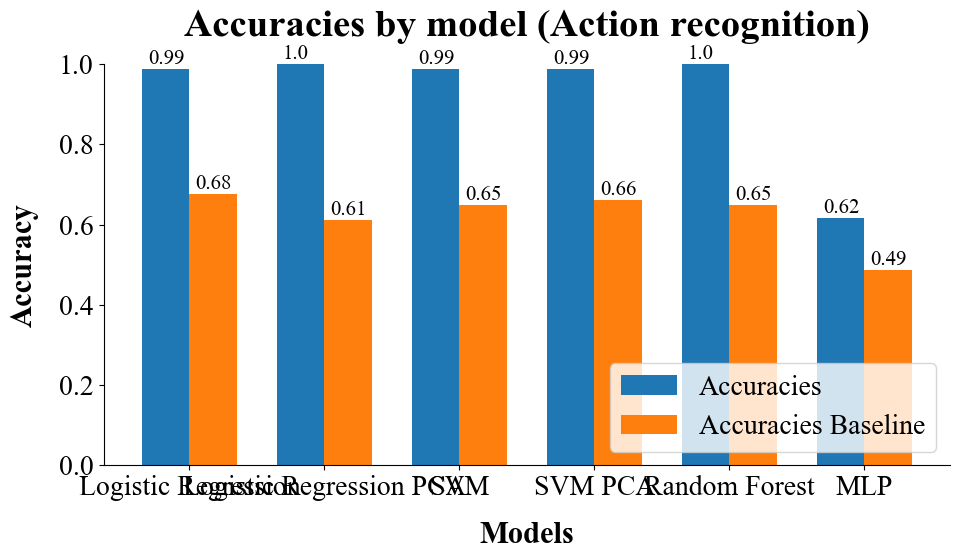

In [59]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies.keys()

dataset_values = [accuracies[model] for model in models]
baseline_values = [accuracies_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (Action recognition)')

ax.set_ylim(0,1)

ax.legend(loc = 'lower right')

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_ExObs.png')
plt.show()